In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import mapclassify

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'

In [3]:
pd.__version__

'2.1.1'

In [4]:
gpd.__version__

'0.14.4'

## Shapefile für den Zensus-Stichtag 15. Mai 2022
Freier Download, Verwendung mit Quellenangabe BKG  
https://www.zensus2022.de/DE/Presse/Grafik/shapefile.html

<Axes: >

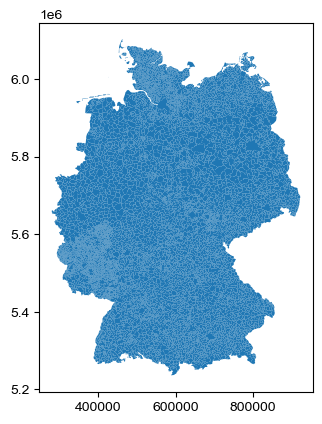

In [5]:
# erzeugt mit mapshaper.org : filter "GF==4"; filter-fields ARS; simplification 4%
gemeindegrenzen = gpd.read_file("VG250_GEM_simplified.zip").set_index("ARS")
gemeindegrenzen.plot()

<Axes: >

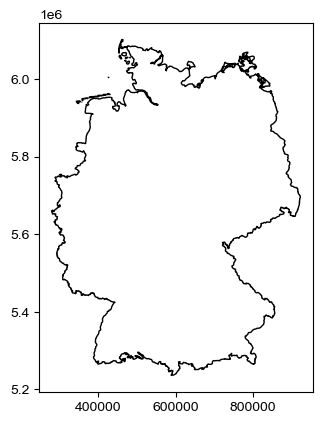

In [6]:
# erzeugt mit mapshaper.org : dissolve
bundesgrenze = gpd.read_file("VG250_DE_simplified.zip")
bundesgrenze.plot(facecolor="None")

<Axes: >

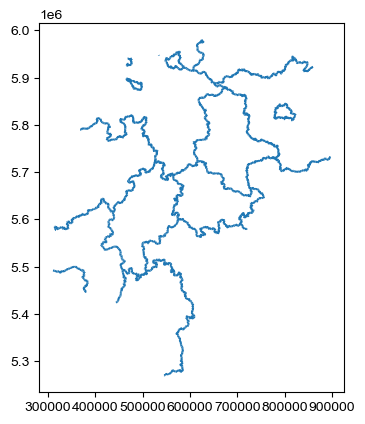

In [7]:
# erzeugt mit mapshaper.org : innerlines where='A.ARS.substring(0,2) != B.ARS.substring(0,2)'
laendergrenzen = gpd.read_file("VG250_LAN_mesh_simplified.zip")
laendergrenzen.plot()

## Ergebnisse des Zensus 2022 ab 25. Juni 2024
Veröffentlichung der Tabellen unter  
https://www.zensus2022.de/DE/Ergebnisse/_inhalt.html#toc-2  
Die dort angebotenen Excel-Dateien, die jeweils ein oder mehrere thematisch gegliederte CSV-Sheets enthalten und die direkt verarbeitet werden können. Die Excel Dateien müssen nicht bearbeitet werden. Getesteter Beispielcode, anschließend einige Hinweise:

## Zeichenerklärung
Aus dem Sheet "Erläuterungen zur Methodik"  

Beispiel **Gebäude- und Wohnungen**  (Vollerhebung)

```
–     = Genau Null oder auf Null geändert
( )   = Aussagewert eingeschränkt, da der Zahlenwert statistisch relativ unsicher ist
.     = Zahlenwert unbekannt oder geheim
```

Beispiel **Bildung und Erwerbstätigkeit** (aus der Stichprobenerhebung hochgerechnete Ergebnisse)  
```
–     = Genau Null oder auf Null geändert
/      = Keine Angabe, da Zahlenwert nicht sicher genug
.      = Zahlenwert unbekannt oder geheim
```

## Hinweise zum Einlesen der Daten (Szenario 1, Daten-csv)
* Die CSV-Sheets können direkt aus der Excel-Datei eingelesen werden, in nachstehendem Beispiel `CSV-Wohnungen`
* Einige Programmversionen von `openpyxl` (Excel-Engine von Pandas) haben in der Vergangenheit Probleme gemacht,  
ggf. Fehlermeldung in Suchmaschine eingeben und Version up- oder downgraden
* Der Regionalschlüssel `_RS` enthält führende Nullen und muss als Zeichenkette (String) eingelesen werden
* Die Datenspalten können neben Ziffern auch Zeichen enthalten, z.B. den längeren Gedankenstrich `–` für _Genau Null oder auf Null geändert_ (dies entspricht dem kürzeren Minuszeichen `-` in Genesis-Systemen), weitere Zeichen entsprechend dem Tabellenblatt Methodenbeschreibung
* Für Statistikzwecke z.B. als `NaN` codieren, hier mit `na_values=` um die Erkennung als Zahl zu erhalten
* Es können deutsche Dezimalkommata vorkommen, daher die Angabe `decimal=","` um die Erkennung als Zahl zu erhalten

In [8]:
regioTabelle_GWZ = pd.read_excel("Regionaltabelle_Gebaeude_Wohnungen.xlsx", 
                                 sheet_name="CSV-Wohnungen",
                                 dtype={"_RS":str}, decimal=",",
                                 na_values=["–","-",".","/","X"])\
                                .set_index("_RS")

## Hinweise zum Einlesen der Daten (Szenario 2, geklammerte Werte)
* Die CSV-Sheets können direkt aus der Excel-Datei eingelesen werden, in nachstehendem Beispiel `CSV-Wohnungen`
* Alles wird zunächst als Zeichenkette (String) eingelesen
* Der Regionalschlüssel `_RS` wird als Index gesetzt
* Die Datenspalten (alle rechts von "Regionalebene) werden mit `.to_numeric(errors="coerce")`  
zu Zahlen konvertiert, einschließlich `NaN` wenn das scheitert
* Durch das Einlesen im Excel-Format werden die landesspezifischen Dezimalzeichen bereits erkannt

In [9]:
regioTabelle_GWZ = pd.read_excel("Regionaltabelle_Gebaeude_Wohnungen.xlsx", 
                                 sheet_name="CSV-Wohnungen",
                                 dtype=str)\
                                .set_index("_RS")

In [10]:
regioTabelle_GWZ.head(7)["QMMIETE"]

_RS
00              7.28
01              7.41
01001           6.96
010010000000    6.96
01002           7.64
010020000000    7.64
01003           7.47
Name: QMMIETE, dtype: object

In [11]:
# keine Ausgabe von Statistiken weil Datenspalte Strings enthält
regioTabelle_GWZ["QMMIETE"].describe()

count     12439
unique      783
top        4.94
freq         64
Name: QMMIETE, dtype: object

### ab Spalte 4 in Zahlen konvertieren, NaN wenn es nicht klappt

In [12]:
for col in regioTabelle_GWZ.columns[3:]:

   regioTabelle_GWZ[col] = pd.to_numeric(regioTabelle_GWZ[col], errors="coerce")    

In [13]:
regioTabelle_GWZ.head(7)

,Berichtszeitpunkt,Name,Regionalebene,GEBAEUDEART_SYS_1,GEBAEUDEART_SYS_11,GEBAEUDEART_SYS_111,GEBAEUDEART_SYS_112,GEBAEUDEART_SYS_12,ZAHLWOHNGN_HHG__1,ZAHLWOHNGN_HHG__2,...,LEERSTAND_DAUER__1,LEERSTAND_DAUER__2,LEERSTAND_DAUER__3,LEERSTAND_DAUER__4,LEERSTAND_GRUND__1,LEERSTAND_GRUND__2,LEERSTAND_GRUND__3,LEERSTAND_GRUND__4,LEERSTAND_GRUND__5,LEERSTAND_GRUND__6
_RS,,,,,,,,,,,,,,,,,,,,,
00,20220515,Deutschland,Bund,43106589,42197376,41806829,390550.0,909210.0,13503722,5567652.0,...,377463.0,235614.0,253437.0,1058468.0,731142.0,460703.0,75614.0,131137.0,142682.0,383709.0
01,20220515,Schleswig-Holstein,Land,1540371,1507353,1496876,10476.0,33020.0,689365,136273.0,...,12299.0,6567.0,5976.0,18398.0,18796.0,9829.0,2196.0,3306.0,2579.0,6538.0
01001,20220515,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,53561,53049,52287,761.0,514.0,11776,1927.0,...,541.0,252.0,226.0,559.0,981.0,290.0,22.0,48.0,27.0,207.0
010010000000,20220515,"Flensburg, Stadt",Gemeinde,53561,53049,52287,761.0,514.0,11776,1927.0,...,541.0,252.0,226.0,559.0,981.0,290.0,22.0,48.0,27.0,207.0
01002,20220515,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,138600,136577,132746,3828.0,2023.0,23634,3910.0,...,1066.0,453.0,453.0,978.0,2016.0,460.0,62.0,117.0,81.0,217.0
010020000000,20220515,"Kiel, Landeshauptstadt",Gemeinde,138600,136577,132746,3828.0,2023.0,23634,3910.0,...,1066.0,453.0,453.0,978.0,2016.0,460.0,62.0,117.0,81.0,217.0
01003,20220515,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,121193,119410,118205,1204.0,1784.0,30665,6634.0,...,939.0,470.0,544.0,1526.0,1582.0,1012.0,142.0,196.0,175.0,375.0


In [14]:
# Alle Werte float64 oder NaN, Statistische Größen können berechnet werden
regioTabelle_GWZ["QMMIETE"].describe()

count    12336.000000
mean         5.836266
std          1.318447
min          1.910000
25%          4.880000
50%          5.600000
75%          6.540000
max         13.840000
Name: QMMIETE, dtype: float64

In [15]:
regioTabelle_GWZ.columns

Index(['Berichtszeitpunkt', 'Name', 'Regionalebene', 'GEBAEUDEART_SYS_1',
       'GEBAEUDEART_SYS_11', 'GEBAEUDEART_SYS_111', 'GEBAEUDEART_SYS_112',
       'GEBAEUDEART_SYS_12', 'ZAHLWOHNGN_HHG__1', 'ZAHLWOHNGN_HHG__2',
       'ZAHLWOHNGN_HHG__3', 'ZAHLWOHNGN_HHG__4', 'ZAHLWOHNGN_HHG__5',
       'BAUJAHR_10JA__01', 'BAUJAHR_10JA__02', 'BAUJAHR_10JA__03',
       'BAUJAHR_10JA__04', 'BAUJAHR_10JA__05', 'BAUJAHR_10JA__06',
       'BAUJAHR_10JA__07', 'BAUJAHR_10JA__08', 'BAUJAHR_10JA__09',
       'BAUJAHR_10JA__10', 'EIGENTUM__1', 'EIGENTUM__2', 'EIGENTUM__3',
       'EIGENTUM__4', 'EIGENTUM__5', 'EIGENTUM__6', 'EIGENTUM__7',
       'EIGENTUM__8', 'HEIZTYP__1', 'HEIZTYP__2', 'HEIZTYP__3', 'HEIZTYP__4',
       'HEIZTYP__5', 'HEIZTYP__6', 'ENERGIETRAEGER__1', 'ENERGIETRAEGER__2',
       'ENERGIETRAEGER__3', 'ENERGIETRAEGER__4', 'ENERGIETRAEGER__5',
       'ENERGIETRAEGER__6', 'ENERGIETRAEGER__7', 'NERGIETRAEGER__8',
       'ENERGIETRAEGER__9', 'NUTZUNG__01', 'NUTZUNG__02', 'NUTZUNG__03',
   

In [16]:
# ausgewählte Datenspalten, die direkt kartiert werden können
regioTabelle_GWZ[regioTabelle_GWZ["Regionalebene"]=="Gemeinde"]\
            [["Name","QMMIETE","LEQ","ETQ","FLAECHE"]]

,Name,QMMIETE,LEQ,ETQ,FLAECHE
_RS,,,,,
010010000000,"Flensburg, Stadt",6.96,2.76,24.85,78.71
010020000000,"Kiel, Landeshauptstadt",7.64,2.08,25.13,73.00
010030000000,"Lübeck, Hansestadt",7.47,2.82,29.64,76.52
010040000000,"Neumünster, Stadt",6.22,3.55,37.28,83.08
010510011011,"Brunsbüttel, Stadt",5.74,3.41,50.09,99.51
...,...,...,...,...,...
160775051011,Göpfersdorf,4.19,11.24,85.19,109.22
160775051023,Langenleuba-Niederhain,4.40,9.99,66.54,97.43
160775051036,Nobitz,4.69,9.06,69.99,99.28


## Daten mit GeoDataFrame aus Shapefile verbinden
Es wird entlang der jeweiligen Indices (Regionalschlüssel) zusammengeführt.  
Die Regionaltabellen als auch das bereitgestellt Shapefile enthalten ebenfalls die Ebenen Gemeindeverbände und Kreise, das Vorgehen wie hier beschreiben würde für diese immer identisch ablaufen.

In [17]:
regioTabelle_GWZ_gem = gemeindegrenzen.join(regioTabelle_GWZ)

In [18]:
regioTabelle_GWZ_gem.head(3)[["Name","geometry","QMMIETE","LEQ","ETQ","FLAECHE"]]

,Name,geometry,QMMIETE,LEQ,ETQ,FLAECHE
ARS,,,,,,
010010000000,"Flensburg, Stadt","POLYGON ((527173.204 6075202.115, 527914.416 6...",6.96,2.76,24.85,78.71
010020000000,"Kiel, Landeshauptstadt","POLYGON ((576003.314 6031749.596, 577425.188 6...",7.64,2.08,25.13,73.00
010030000000,"Lübeck, Hansestadt","POLYGON ((624906.198 5980395.728, 625243.141 5...",7.47,2.82,29.64,76.52


## Karte zeichnen/ausgeben
Zur massenhaften schnellen Exploration empfiehlt sich die Klasseneinteilung mit `NaturalBreaks` (Jenks).  
Wählt man später mit `userdefined` Klassengrenzen, kann man auch das Zahlenformat `fmt` der Legende anpassen, z.B. `{:.0f}` für ganze Zahlen.  
Als Farbschemata können u.a. [Colorbrewer](https://colorbrewer2.org/#type=sequential&scheme=PuBuGn&n=6)-Kürzel wie `PuGn` oder `viridis` verwendet werden.

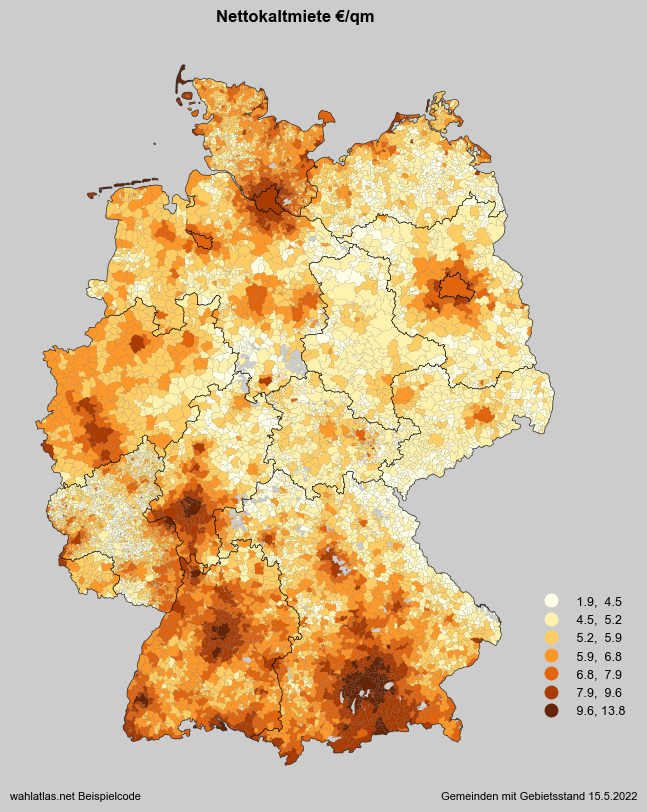

In [19]:
fig, ax = plt.subplots(1, figsize=(12,10))
fig.set_facecolor("#ccc")
ax.axis("off")

ax.set_title("Nettokaltmiete €/qm", fontdict={"fontsize":12, "fontweight": "bold"})
ax.annotate("wahlatlas.net Beispielcode", xy=(0,0), xycoords="axes fraction", ha="left", fontsize=8)
ax.annotate("Gemeinden mit Gebietsstand 15.5.2022", xy=(1.1,0), xycoords="axes fraction", ha="right", fontsize=8)
bundesgrenze.plot(facecolor = "None", linewidth = 1, edgecolor = "#333", ax=ax )

regioTabelle_GWZ_gem.plot(column = "QMMIETE", cmap = "YlOrBr",
                          scheme = "NaturalBreaks", k=7,
                          #scheme = "userdefined", classification_kwds = {"bins": [10,20,30,40,50,60,70]},
                          legend = True, legend_kwds = {"fmt": "{:.1f}", "frameon": False,
                                                       "markerscale": 1, "fontsize": 9,
                                                       "bbox_to_anchor": (1.1, 0.28)},
                          linewidth = .05, edgecolor = "#333", ax=ax )

laendergrenzen.plot(facecolor = "None", linewidth = .5, edgecolor = "#000", ax=ax )
plt.savefig("meine_Karte_Zensus2022.png", bbox_inches="tight", pad_inches=.15, dpi=96) #  .svg | .pdf | .png
plt.show()

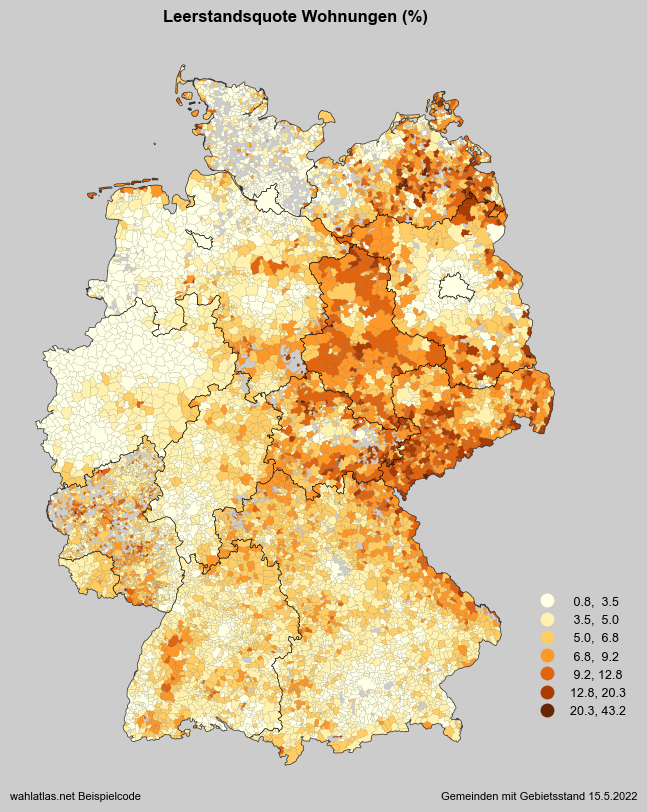

In [20]:
fig, ax = plt.subplots(1, figsize=(12,10))
fig.set_facecolor("#ccc")
ax.axis("off")

ax.set_title("Leerstandsquote Wohnungen (%)", fontdict={"fontsize":12, "fontweight": "bold"})
ax.annotate("wahlatlas.net Beispielcode", xy=(0,0), xycoords="axes fraction", ha="left", fontsize=8)
ax.annotate("Gemeinden mit Gebietsstand 15.5.2022", xy=(1.1,0), xycoords="axes fraction", ha="right", fontsize=8)
bundesgrenze.plot(facecolor = "None", linewidth = 1, edgecolor = "#333", ax=ax )

regioTabelle_GWZ_gem.plot(column = "LEQ", cmap = "YlOrBr",
                          scheme = "NaturalBreaks", k=7,
                          #scheme = "userdefined", classification_kwds = {"bins": [10,20,30,40,50,60,70]},
                          legend = True, legend_kwds = {"fmt": "{:.1f}", "frameon": False,
                                                       "markerscale": 1, "fontsize": 9,
                                                       "bbox_to_anchor": (1.1, 0.28)},
                          linewidth = .05, edgecolor = "#333", ax=ax )

laendergrenzen.plot(facecolor = "None", linewidth = .5, edgecolor = "#000", ax=ax )
plt.savefig("meine_Karte_Zensus2022.png", bbox_inches="tight", pad_inches=.15, dpi=96) #  .svg | .pdf | .png
plt.show()